In [11]:
# @title Initialisation
# Import libraries for data manipulation
import numpy as np
import pandas as pd
import math as mt

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# uncomment and run the following lines for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# @title Reading the measurements
#Adding the pathes & file names for Experimental Case 1
path2="/content/drive/MyDrive/MyPythonProjects/2024/Pipeline/pFS150kA_50m/"
#/content/drive/MyDrive/MyPythonProjects/2024/Pipeline/pFS150kA_50m/iLeft.csv
# List of file names
file_names = [
    "iLeft.csv",
    "to_SPD1.csv",
    "viaSPD2.csv"
]
# List of labels:
label_names= [
    "iLeft",
    "to_SPD1",
    "iSPD2"
]
# Dictionary to hold the dataframes
dfs = {}

# Loop through the file names, read the data, and process it (converting from µs to second!)
#for i, file_name in enumerate(file_names):
#    df_tmp = pd.read_csv(path2 + file_name, encoding='latin1', skiprows=3, sep=';', decimal=',')
#    df_tmp = df_tmp.iloc[:, [0, 1]]  # Selecting only the first two columns
#    df_tmp.columns = ['Time, us', 'Current, A']  # Renaming the columns
#    #dfs[f'df_XGSLab_GPR_{file_name.split("_")[0]}_BM{file_name.split("_")[1][2]}'] = df_tmp
#    dfs[label_names[i]] = df_tmp
for i, file_name in enumerate(file_names):
    df_tmp = pd.read_csv(path2 + file_name, encoding='latin1', skiprows=3, sep=';', decimal=',')
    df_tmp = df_tmp.iloc[:, [0, 1]]  # Selecting only the first two columns
    df_tmp.columns = ['Time, us', 'Current, A']  # Renaming the columns
    df_tmp['Time, us'] = df_tmp['Time, us'] * 1e-6  # Convert time from microseconds to seconds
    # Updating the column name to reflect the unit change
    df_tmp.rename(columns={'Time, us': 'Time, s'}, inplace=True)
    dfs[label_names[i]] = df_tmp

# Example of how to access the dataframes and print their info
for key, df in dfs.items():
    print(f"Doublechecking {key}:")
    print(f"Head of {key} with a shape {df.shape}:")
    print(df.head(), '\n')


Doublechecking iLeft:
Head of iLeft with a shape (262143, 2):
        Time, s   Current, A
0  2.500010e-08  1826.207456
1  5.000019e-08  1824.711139
2  7.500029e-08  1823.216239
3  1.000004e-07  1821.723744
4  1.250005e-07  1820.234977 

Doublechecking to_SPD1:
Head of to_SPD1 with a shape (262143, 2):
        Time, s   Current, A
0  2.500010e-08 -1190.502320
1  5.000019e-08 -1191.816056
2  7.500029e-08 -1193.136897
3  1.000004e-07 -1194.479115
4  1.250005e-07 -1195.842616 

Doublechecking iSPD2:
Head of iSPD2 with a shape (262143, 2):
        Time, s  Current, A
0  2.500010e-08  143.337174
1  5.000019e-08  143.623716
2  7.500029e-08  143.910021
3  1.000004e-07  144.195729
4  1.250005e-07  144.480788 



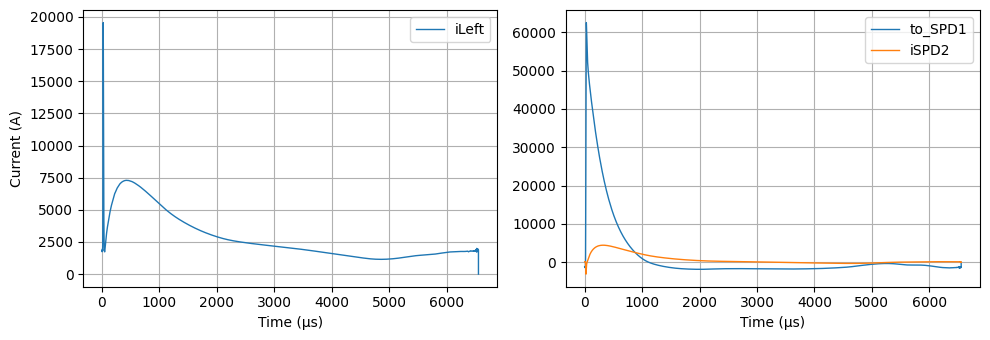

In [13]:
# @title Plotting as it is
# dfs is already populated with the dataframes (!)

fig1, axs1 = plt.subplots(1, 2, figsize=(10, 3.5))  # Adjust the figsize as needed

# Plotting the 'iLeft' dataframe on the first subplot
axs1[0].plot(dfs['iLeft']['Time, s'] / 1e-6, dfs['iLeft']['Current, A'], linewidth=1.0, label='iLeft')
axs1[0].set_xlabel('Time (µs)')
axs1[0].set_ylabel('Current (A)')
axs1[0].grid(True)
# axs1[0].set_xlim(0, 1000)
#axs1[0].set_ylim(0, 2000)
axs1[0].legend()

# Plotting the 'iSPD1' and 'iSPD2' dataframes on the second subplot
axs1[1].plot(dfs['to_SPD1']['Time, s'] / 1e-6, dfs['to_SPD1']['Current, A'], linewidth=1.0, label='to_SPD1')
axs1[1].plot(dfs['iSPD2']['Time, s'] / 1e-6, dfs['iSPD2']['Current, A'], linewidth=1.0, label='iSPD2')
axs1[1].set_xlabel('Time (µs)')
# axs1[1].set_ylabel('Current (A)')  # No need to set ylabel again if it's the same as the first subplot
# axs1[1].set_xlim(0, 1000)
#axs1[1].set_ylim(0, 2000)
axs1[1].grid(True)
axs1[1].legend()

plt.tight_layout()  # Adjust layout to make it more compact and readable
plt.show()


Offset current: 1846.120258689205 A
Specific energy until 3500.0 µs: 27.508513403417297 kJ/Ω


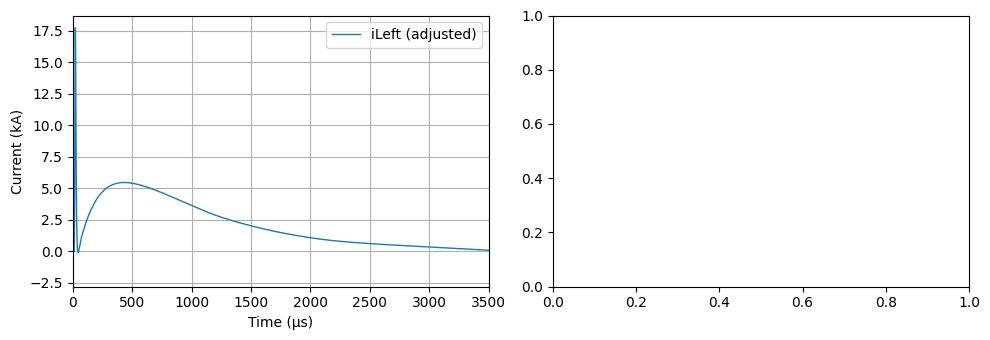

In [14]:
#Lets do some Pre-Processing
# Getting away that offsets:
# Pre-processing steps as provided
df_i = dfs['iLeft']  # Assuming dfs['iLeft'] already exists
end_time_for_partialCurrent = 3500e-6  # in seconds, for specific energy calculation

# Convert 10 microseconds to seconds for comparison
end_time_for_Offset = 10e-6

# Calculate offset current
start_time_index = df_i[df_i['Time, s'] <= end_time_for_Offset].index[-1]
offset_current = df_i.loc[:start_time_index, 'Current, A'].mean()
# Adjusting current by subtracting the offset
dfs['iLeft']['Adjusted Current, A'] = dfs['iLeft']['Current, A'] - offset_current

# Calculate specific energy
time_s = dfs['iLeft']['Time, s'].values
current_adjusted = dfs['iLeft']['Adjusted Current, A'].values
indices = np.where(time_s <= end_time_for_partialCurrent)[0]
current_squared = current_adjusted[indices] ** 2
dt = np.diff(time_s[indices])
energy = np.sum(0.5 * (current_squared[:-1] + current_squared[1:]) * dt) / 1000  # kJ/Ω

print(f"Offset current: {offset_current} A")
print(f"Specific energy until {end_time_for_partialCurrent*1e6} µs: {energy} kJ/Ω")

# Plotting
fig1, axs1 = plt.subplots(1, 2, figsize=(10, 3.5))

# Adjusted 'iLeft' current plot
axs1[0].plot(dfs['iLeft']['Time, s'] * 1e6, dfs['iLeft']['Adjusted Current, A'] / 1e3, linewidth=1.0, label='iLeft (adjusted)')
axs1[0].set_xlabel('Time (µs)')
axs1[0].set_ylabel('Current (kA)')
axs1[0].grid(True)
axs1[0].set_xlim(0, end_time_for_partialCurrent * 1e6)  # x-axis limit set to 3500 µs
axs1[0].legend()

plt.tight_layout()
plt.show()



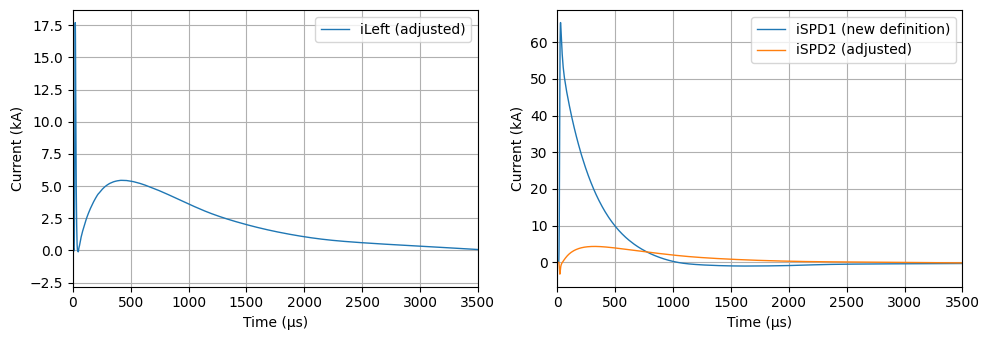

Specific energy of iLeft until 3500 µs: 27.508513403417297 kJ/Ω
Specific energy for SPD1 until 3500 µs: 570.2717554377219 kJ/Ω
Specific energy for SPD2 until 3500 µs: 11.961227494342669 kJ/Ω
Total specific energy until 3500 µs: 609.7414963354819 kJ/Ω


In [16]:
# Assuming dfs contains your dataframes for 'to_SPD1.csv' and 'viaSPD2.csv'
end_time_for_partialCurrent = 3500e-6  # in seconds, for specific energy calculation
end_time_for_Offset = 10e-6  # Convert 10 microseconds to seconds for comparison

fig1, axs1 = plt.subplots(1, 2, figsize=(10, 3.5))  # Adjust the figsize as needed

def adjust_current_and_calculate_energy(df, end_time_for_Offset, end_time_for_partialCurrent):
    start_time_index = df[df['Time, s'] <= end_time_for_Offset].index[-1]
    offset_current = df.loc[:start_time_index, 'Current, A'].mean()
    df['Adjusted Current, A'] = df['Current, A'] - offset_current

    # Calculate specific energy
    time_s = df['Time, s'].values
    current_adjusted = df['Adjusted Current, A'].values
    indices = np.where(time_s <= end_time_for_partialCurrent)[0]
    current_squared = current_adjusted[indices] ** 2
    dt = np.diff(time_s[indices])
    energy = np.sum(0.5 * (current_squared[:-1] + current_squared[1:]) * dt) / 1000  # kJ/Ω
    return df, energy

# Adjust currents and calculate energies for all three
dfs['iLeft'], energy_iLeft = adjust_current_and_calculate_energy(dfs['iLeft'], end_time_for_Offset, end_time_for_partialCurrent)
dfs['iSPD1'], energy_iSPD1 = adjust_current_and_calculate_energy(dfs['to_SPD1'], end_time_for_Offset, end_time_for_partialCurrent)
dfs['iSPD2'], energy_iSPD2 = adjust_current_and_calculate_energy(dfs['iSPD2'], end_time_for_Offset, end_time_for_partialCurrent)

# Compute new iSPD1 as the difference between adjusted currents of 'to_SPD1' and 'viaSPD2'
dfs['iSPD1'] = dfs['to_SPD1'].copy()
dfs['iSPD1']['Adjusted Current, A'] = dfs['to_SPD1']['Adjusted Current, A'] - dfs['iSPD2']['Adjusted Current, A']

# Plotting
# iLeft on the left subplot
axs1[0].plot(dfs['iLeft']['Time, s'] * 1e6, dfs['iLeft']['Adjusted Current, A'] / 1e3, linewidth=1.0, label='iLeft (adjusted)')
axs1[0].set_xlabel('Time (µs)')
axs1[0].set_ylabel('Current (kA)')
axs1[0].grid(True)
axs1[0].set_xlim(0, end_time_for_partialCurrent * 1e6)
axs1[0].legend()

# New iSPD1 and viaSPD2 on the right subplot
axs1[1].plot(dfs['iSPD1']['Time, s'] * 1e6, dfs['iSPD1']['Adjusted Current, A'] / 1e3, linewidth=1.0, label='iSPD1 (new definition)')
axs1[1].plot(dfs['iSPD2']['Time, s'] * 1e6, dfs['iSPD2']['Adjusted Current, A'] / 1e3, linewidth=1.0, label='iSPD2 (adjusted)')
axs1[1].set_xlabel('Time (µs)')
axs1[1].set_ylabel('Current (kA)')
axs1[1].grid(True)
axs1[1].set_xlim(0, end_time_for_partialCurrent * 1e6)
axs1[1].legend()

plt.tight_layout()
plt.show()

# Print specific energies
print(f"Specific energy of iLeft until 3500 µs: {energy_iLeft} kJ/Ω")
print(f"Specific energy for SPD1 until 3500 µs: {energy_iSPD1} kJ/Ω")
print(f"Specific energy for SPD2 until 3500 µs: {energy_iSPD2} kJ/Ω")
# Calculate the total specific energy
total_specific_energy = energy_iLeft + energy_iSPD1 + energy_iSPD2

# Print the total specific energy
print(f"Total specific energy until 3500 µs: {total_specific_energy} kJ/Ω")
